<a href="https://colab.research.google.com/github/SreeBhagya-S/TKM_21/blob/main/BERT_Mail_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

In [ ]:
import pandas as pd

df = pd.read_csv('/content/spam2.csv',encoding='cp1252')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3433,spam,Camera - You are awarded a SiPix Digital Camer...,1
1444,spam,Free 1st week entry 2 TEXTPOD 4 a chance 2 win...,1
5484,ham,", , and picking them up from various points ...",0
2691,spam,sports fans - get the latest sports news str* ...,1
65,spam,"As a valued customer, I am pleased to advise y...",1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
X_train.head(4)

3010    Update_Now - 12Mths Half Price Orange line ren...
4475    Want explicit SEX in 30 secs? Ring 02073162414...
2769                           I am on the way to ur home
1904    Free entry in 2 a weekly comp for a chance to ...
Name: Message, dtype: object

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 506s 14s/step - loss: 0.6956 - accuracy: 0.5482 - precision: 0.5506 - recall: 0.5250
Epoch 2/10
35/35 [==============================] - 485s 14s/step - loss: 0.5496 - accuracy: 0.7777 - precision: 0.7792 - recall: 0.7750
Epoch 3/10
35/35 [==============================] - 483s 14s/step - loss: 0.4562 - accuracy: 0.8446 - precision: 0.8217 - recall: 0.8804
Epoch 4/10
35/35 [==============================] - 480s 14s/step - loss: 0.3989 - accuracy: 0.8750 - precision: 0.8659 - recall: 0.8875
Epoch 5/10
35/35 [==============================] - 484s 14s/step - loss: 0.3623 - accuracy: 0.8938 - precision: 0.8795 - recall: 0.9125
Epoch 6/10
35/35 [==============================] - 486s 14s/step - loss: 0.3491 - accuracy: 0.8866 - precision: 0.8778 - recall: 0.8982
Epoch 7/10
35/35 [==============================] - 482s 14s/step - loss: 0.3180 - accuracy: 0.8929 - precision: 0.8793 - recall: 0.9107
Epoch 8/10
35/35 [=======================

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 169s 13s/step - loss: 0.3127 - accuracy: 0.8797 - precision: 0.8586 - recall: 0.9091


[0.3127098083496094,
 0.8796791434288025,
 0.8585858345031738,
 0.9090909361839294]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[159,  28],
       [ 17, 170]])

Text(33.0, 0.5, 'Truth')

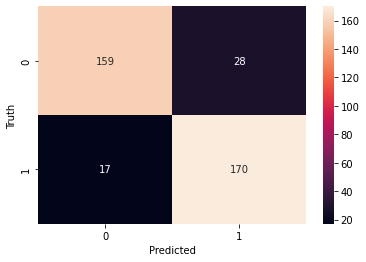

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       187
           1       0.86      0.91      0.88       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
m=model.predict(reviews)
m

array([[0.74621695],
       [0.8238832 ],
       [0.7619685 ],
       [0.17692724],
       [0.11576137]], dtype=float32)